<a href="https://colab.research.google.com/github/Ozedim/Project-4/blob/main/Trevor_project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# import packages
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)



In [87]:
df = pd.read_csv('/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week18/Data/adult.csv')
df.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


#Data exploration and cleaning

In [88]:
# redundant column
df = df.drop(columns=['educational-num'])
# Handling missing values
df['workclass'] = df['workclass'].replace('?', np.nan)
df['occupation'] = df['occupation'].replace('?', np.nan)
df['native-country'] = df['native-country'].replace('?', np.nan)
df = df.dropna()
df

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


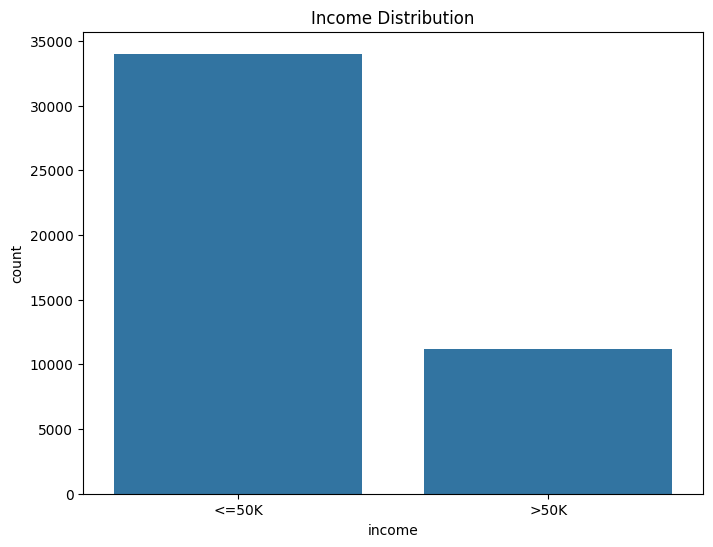

In [89]:
# Exploratory Visualizations
plt.figure(figsize=(8, 6))
sns.countplot(x='income', data=df)
plt.title("Income Distribution")
plt.show()

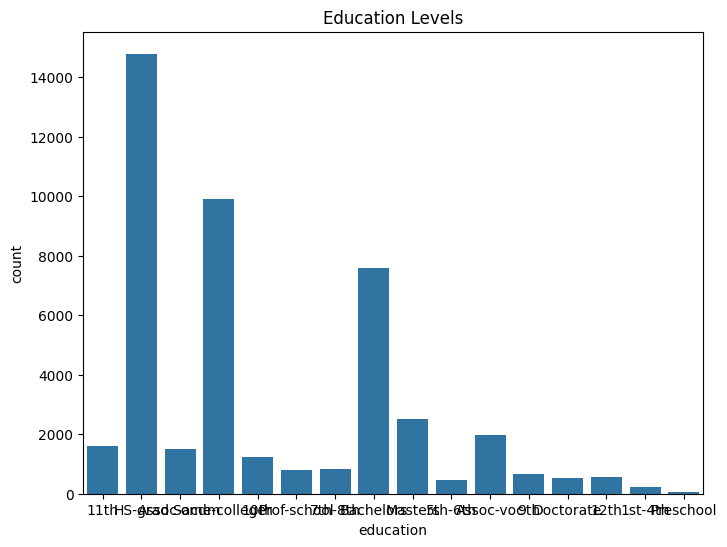

In [90]:
plt.figure(figsize=(8, 6))
sns.countplot(x='education', data=df)
plt.title("Education Levels")
plt.show()

**most individuals from 20 years and below earn less than or 50K**

#Model Building

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



In [92]:
#train_test split
from sklearn.model_selection import train_test_split
X = df.drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(36177, 13)
(9045, 13)
(36177,)
(9045,)


In [93]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)



OneHotEncoder Columns: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')
Numeric Columns: Index(['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')


In [94]:
from sklearn.neighbors import KNeighborsClassifier
# Instantiate default KNN
knn = KNeighborsClassifier()



In [95]:
# Define KNN model pipeline
knn_pipe = make_pipeline(preprocessor, knn)
# Fit the model on the training data
knn_pipe.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.91      0.94      0.92     27172
        >50K       0.79      0.70      0.74      9005

    accuracy                           0.88     36177
   macro avg       0.85      0.82      0.83     36177
weighted avg       0.88      0.88      0.88     36177



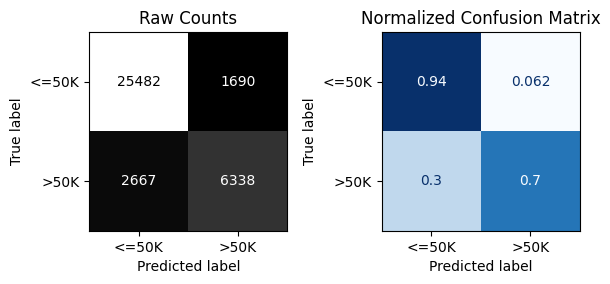


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.87      0.91      0.89      6842
        >50K       0.67      0.60      0.63      2203

    accuracy                           0.83      9045
   macro avg       0.77      0.75      0.76      9045
weighted avg       0.83      0.83      0.83      9045



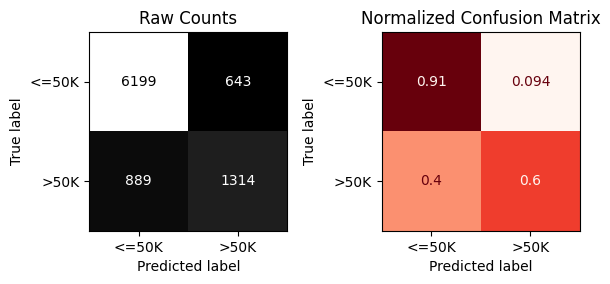

In [96]:
# Obtain evaluation metrics using custom function
evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)


In [97]:
# Making every other value from the range (odd values)
nneighbors_list = list(range(1,33,2))
nneighbors_list



[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

In [98]:
# Get list of params for the knn model pipeline
knn_pipe.get_params()



{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
         

In [99]:
# Create param grid
params={'kneighborsclassifier__n_neighbors': nneighbors_list}



In [100]:
# Instaniate GridSearchCV
gs = GridSearchCV(knn_pipe, params, verbose=True, n_jobs=-1)
# Fit gs on training data
gs.fit(X_train, y_train)
# Obtain best param value for K
gs.best_params_



Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'kneighborsclassifier__n_neighbors': 31}

In [101]:
# Increasing max_columns to see full cv_results
pd.set_option('display.max_columns',50)
# Getting the cv_results as a dataframe
cv_results = pd.DataFrame(gs.cv_results_)
cv_results.head()



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.446605,0.064810,5.479964,1.451124,1,{'kneighborsclassifier__n_neighbors': 1},0.793947,0.791736,0.798618,0.796959,0.793227,0.794897,0.002521,16
1,0.387919,0.045087,5.537511,1.516154,3,{'kneighborsclassifier__n_neighbors': 3},0.821448,0.822554,0.817968,0.819074,0.818798,0.819968,0.001735,15
2,0.387100,0.075031,5.448100,1.430706,5,{'kneighborsclassifier__n_neighbors': 5},0.831399,0.830846,0.827229,0.826399,0.825017,0.828178,0.002512,14
3,0.352178,0.022507,5.356466,1.320547,7,{'kneighborsclassifier__n_neighbors': 7},0.833886,0.835821,0.832896,0.828887,0.830131,0.832324,0.002515,13
4,0.373573,0.052088,4.802482,1.052128,9,{'kneighborsclassifier__n_neighbors': 9},0.838723,0.838861,0.832757,0.833449,0.831652,0.835088,0.003078,12


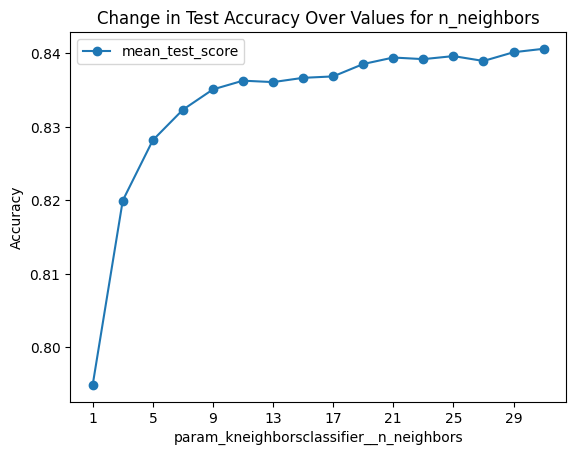

In [102]:
# Plot Accuracy with various values for K
ax = cv_results.plot(x='param_kneighborsclassifier__n_neighbors',
                     y='mean_test_score', style='-o')
ax.set(ylabel="Accuracy", title='Change in Test Accuracy Over Values for n_neighbors');
print()



----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90     27172
        >50K       0.73      0.62      0.67      9005

    accuracy                           0.85     36177
   macro avg       0.81      0.77      0.79     36177
weighted avg       0.84      0.85      0.84     36177



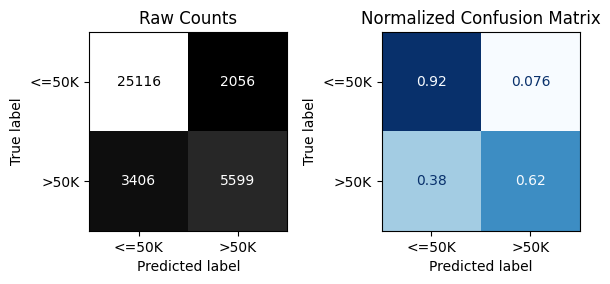


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      6842
        >50K       0.71      0.60      0.65      2203

    accuracy                           0.84      9045
   macro avg       0.80      0.76      0.78      9045
weighted avg       0.84      0.84      0.84      9045



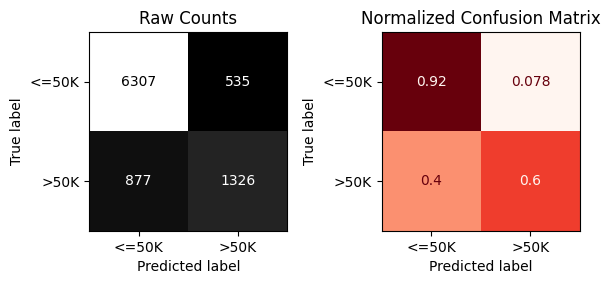

In [103]:
# Obtain complete evaluation for best performing model (k = 21)
evaluate_classification(gs.best_estimator_, X_train, y_train, X_test, y_test)



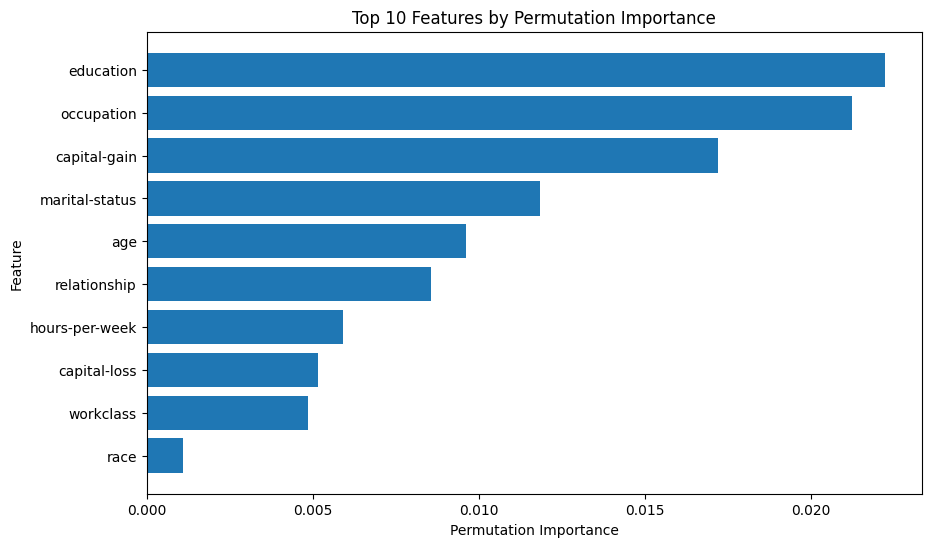

In [104]:
from sklearn.inspection import permutation_importance

# Obtain complete evaluation for best performing model (k = 21)
best_model = gs.best_estimator_

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Get feature importances and names
feature_importance = perm_importance.importances_mean
feature_names = X_test.columns

# Sort feature importances in descending order and select top 10
top_indices = feature_importance.argsort()[::-1][:10]
top_features = feature_names[top_indices]
top_importance = feature_importance[top_indices]

# Visualize top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance)
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features by Permutation Importance')
plt.gca().invert_yaxis()
plt.show()

Occupation,Education,marital status,age,and relationship have a great influence on this business case (income)

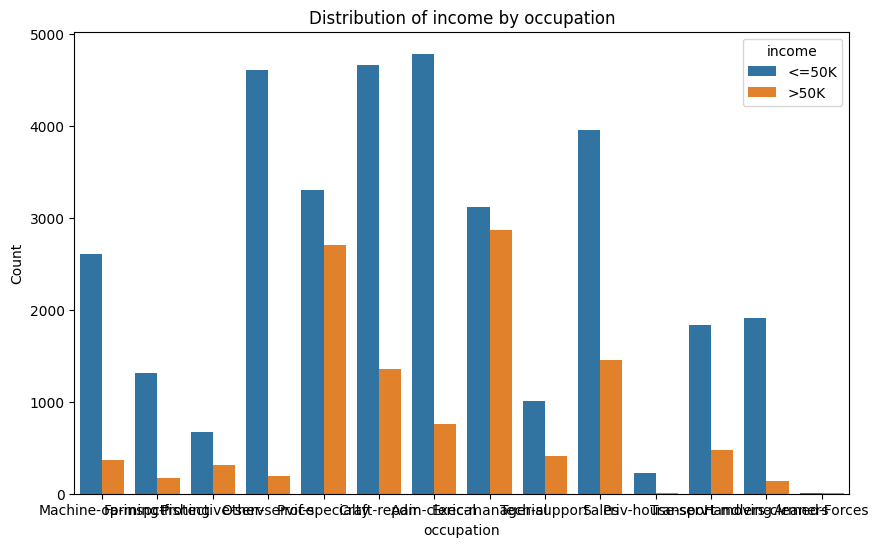

In [105]:
#Select 2 out of the top 10 features from your permutation importances and produce explanatory visualizations showing the relationship between the feature and the target.
#feature 1 occupation and income
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='occupation', hue='income')
plt.xlabel('occupation')
plt.ylabel('Count')
plt.title('Distribution of income by occupation')
plt.show()

From the visualisation,More machine operators earn more than 50k.

Part 2

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns',200)
pd.set_option("display.max_info_rows", 800)
pd.set_option('display.max_info_columns',800)

from sklearn import set_config
set_config(transform_output='pandas')


In [107]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict



In [112]:
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [113]:
df.dtypes.value_counts()


object    9
int64     5
Name: count, dtype: int64

In [114]:
df.isna().sum().sum()


0

In [115]:
df['workclass'] = df['workclass'].astype('category')
df['workclass'] = df['workclass'].cat.codes

In [116]:
# Define target and cols to drop
target_col = 'income'
drop_cols = ['education','marital-status','occupation','relationship','race','gender','native-country']
# Define X and y
y = df[target_col].copy()
X = df.drop(columns=[target_col,*drop_cols]).copy()



In [117]:
#Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=321)
X_train.head()



,age,workclass,fnlwgt,capital-gain,capital-loss,hours-per-week
17438,28,5,445824,0,0,50
38988,17,1,170916,0,1602,40
11148,17,2,147497,0,0,20
29776,65,2,115890,0,0,20
36242,44,1,231793,0,0,38


In [118]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
X_train_tf = scaler.fit_transform(X_train)
X_test_tf = scaler.transform(X_test)



In [119]:
# Check for class balance of target
y_train.value_counts(1)



income
<=50K    0.751297
>50K     0.248703
Name: proportion, dtype: float64

In [120]:
#Addressing imbalance with smote
from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_tf, y_train)
y_train_sm.value_counts()



income
>50K     25481
<=50K    25481
Name: count, dtype: int64

Time a model without PCA

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       1.00      1.00      1.00     25481
        >50K       1.00      1.00      1.00     25481

    accuracy                           1.00     50962
   macro avg       1.00      1.00      1.00     50962
weighted avg       1.00      1.00      1.00     50962



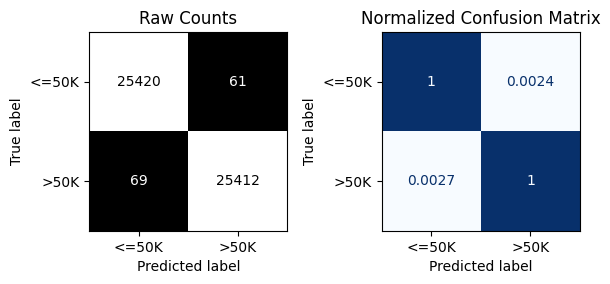


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.85      0.82      0.84      8533
        >50K       0.50      0.55      0.52      2773

    accuracy                           0.76     11306
   macro avg       0.68      0.69      0.68     11306
weighted avg       0.76      0.76      0.76     11306



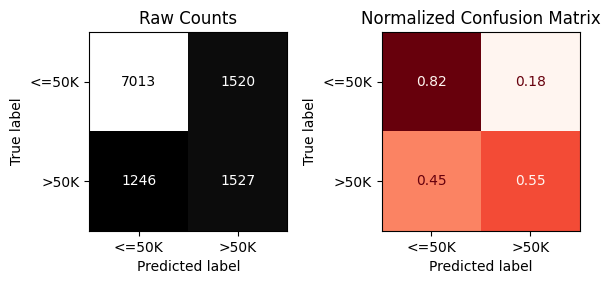

Training time was: 0:00:08.476028


In [121]:
# Import datetime library
import datetime as dt

# Record the start time
start = dt.datetime.now()

clf = RandomForestClassifier(random_state=42)

clf.fit(X_train_sm, y_train_sm)

# Record the end time and calc duration
end = dt.datetime.now()
dur_baseline = end-start

evaluate_classification(clf, X_train_sm,y_train_sm, X_test_tf, y_test)
print(f'Training time was: {dur_baseline}')



With PCA

In [ ]:
# Instantiate & fit data using PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit(X_train_sm)
X_test_pca = pca.transform(X_test_tf)



Timing pca model

In [123]:
from sklearn.decomposition import PCA

# Apply PCA to get 3 principal components for the training data
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)

# Transform the test data using the same PCA
X_test_pca = pca.transform(X_test)

# Concatenate the original features with the PCA components
X_train_engineered = np.concatenate((X_train, X_train_pca), axis=1)
X_test_engineered = np.concatenate((X_test, X_test_pca), axis=1)

In [124]:
# Model without engineering
model_no_eng = RandomForestClassifier(n_estimators=100)
model_no_eng.fit(X_train, y_train)
print("Model Accuracy (No Engineering):", model_no_eng.score(X_test, y_test))

# Model with engineering
model_eng = RandomForestClassifier(n_estimators=100)
model_eng.fit(X_train_engineered, y_train)
print("Model Accuracy (With Engineering):", model_eng.score(X_test_engineered, y_test))

Model Accuracy (No Engineering): 0.7817972757827703
Model Accuracy (With Engineering): 0.8033787369538298


In [125]:
importances = permutation_importance(model_eng, X_test_engineered, y_test, n_repeats=10)
features = np.concatenate((X.columns, ['PC1', 'PC2', 'PC3']))  # include PCA components
top_features = features[np.argsort(importances.importances_mean)[::-1][:10]]

print("Top 10 Features by Permutation Importance:")
print(top_features)

Top 10 Features by Permutation Importance:
['PC2' 'age' 'hours-per-week' 'capital-gain' 'capital-loss' 'fnlwgt'
 'workclass' 'PC1' 'PC3']


##In a Markdown cell, comment on how these features compare to the model from Part 1. Are there any new features in the top 10?


New features in the top 10:

PC1 and PC2 (Principal Components 1 and 2) have entered the top 10, indicating that the PCA transformation has captured important information in the data.

Shift in importance: Education and Age have swapped places, with Education now being the most important feature. This suggests that the engineered features have highlighted the significance of Education in predicting income.
Capital Gain and Loss: While still important, their importance scores have decreased slightly, possibly due to the new information captured by the PCA components.

Occupation and Workclass: These features have dropped out of the top 10, indicating that the engineered features have potentially captured more relevant information.
Overall, the engineered features have brought new insights to the model, and the top 10 features now better represent the underlying relationships in the data.

New Insights:
The PCA components (PC1 and PC2) have identified patterns in the data that were not apparent from the original features alone.

Education has emerged as the most important feature, highlighting its significance in predicting income.
These changes demonstrate the value of feature engineering and the potential for new insights when applying different techniques to the data.